The following line installs the pyDOE2 package, which is used to generate well-distributed sample points in a multi-dimensional space. These points are crucial for training machine learning models or solving complex equations where we need to explore the entire domain effectively — especially when working in higher dimensions like 2D or 3D.

In [ ]:
!pip install pyDOE2

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25523 sha256=9f22c5bf6474e4fcfbb1cf01808fa80a3eb6a256d2273d9f6588cdbdb05ddc53
  Stored in directory: /root/.cache/pip/wheels/56/11/60/a0b234151910cf9cff9fdc072f5d42e3c35157b649dbdff3ef
Successfully built pyDOE2


This snippet sets up the core libraries and basic parameters needed for our simulation. TensorFlow is used to build and train the model, while NumPy handles array operations and Matplotlib helps us visualize results. The pyDOE2 library is brought in to generate well-distributed sample points across the domain using Latin Hypercube Sampling — a strategy that's especially helpful when working in higher dimensions.

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pyDOE2 import lhs


By setting random seeds, we ensure that the behavior of the model remains consistent across runs. The parameters defined here include a small constant that influences how sharp or diffuse the interface will be, a pair of sample sizes for different parts of the model training, and the bounds of the simulation domain — which spans two spatial dimensions and time.

In [35]:

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
epsilon = 0.01
N_f = 10000
N_u = 10000
lb = np.array([-1.0, -1.0, 0.0])
ub = np.array([1.0, 1.0, 2.0])

This function defines the initial condition for our simulation — a sharp disc-shaped profile centered at the origin. It uses the radial distance from the center to determine how the value transitions from inside to outside the disc. The tanh function provides a smooth but steep transition controlled by the delta parameter, which essentially controls how sharp the interface appears. This kind of profile is especially useful when modeling phase boundaries or evolving interfaces in two dimensions.

In [36]:
# Initial condition (sharp disc)
def initial_condition(X):
    R = 0.5
    delta = 0.02
    x, y = X[:, 0], X[:, 1]
    r = tf.sqrt((x - 0.0)**2 + (y - 0.0)**2)
    return 0.5 * (1 + tf.tanh((R - r) / delta)).numpy().reshape(-1, 1)

The **collocation points** — the coordinates where the model will enforce the physics of the equation during training is generated in this section.

To capture fine details near the evolving interface, we strategically place 2000 points in a narrow **ring-shaped region** around a radius of 0.5 using polar coordinates. These points help the model focus on regions where the solution is expected to change rapidly.

The remaining points are filled using **Latin Hypercube Sampling (LHS)** across the full 3D domain (x, y, t). This ensures that the model gets a diverse and well-distributed set of training points. By combining the ring and LHS points, we strike a balance between precision near critical areas and coverage of the entire domain.


In [37]:
# Collocation points
theta = 2 * np.pi * np.random.rand(2000)
r = 0.5 + 0.05 * np.random.randn(2000)
x_ring = (r * np.cos(theta)).reshape(-1, 1)
y_ring = (r * np.sin(theta)).reshape(-1, 1)
t_ring = np.random.rand(2000, 1) * 2.0
X_ring = np.hstack([x_ring, y_ring, t_ring])
X_f_lhs = lb + (ub - lb) * lhs(3, N_f - 2000)
X_f = np.vstack([X_ring, X_f_lhs])

This part prepares the **initial condition (IC) training points** — the locations at which the model will learn the state of the system at time zero.

We create a uniform grid of points across the 2D spatial domain (x and y) and set their time component to zero, representing the initial snapshot of the system. The initial values at these points are computed using the `initial_condition` function, which provides the disc profile.

To further anchor the solution and ensure stability, we explicitly add the **center point of the disc** (0, 0, 0) with a known value of 1. This helps the model strongly learn the maximum value at the disc center, where the interface begins.


In [38]:
# IC points
x_ic = np.linspace(-1, 1, int(np.sqrt(N_u)))
y_ic = np.linspace(-1, 1, int(np.sqrt(N_u)))
xm, ym = np.meshgrid(x_ic, y_ic)
x_flat = xm.flatten()[:, None]
y_flat = ym.flatten()[:, None]
t_flat = np.zeros_like(x_flat)
X_ic = np.hstack([x_flat, y_flat, t_flat])
u_ic = initial_condition(X_ic)

# Add center anchor
X_ic = np.vstack([X_ic, [[0.0, 0.0, 0.0]]])
u_ic = np.vstack([u_ic, [[1.0]]])

Physics-Informed Neural Network (PINN) — a neural model designed not just to fit data, but to learn solutions that satisfy a partial differential equation (PDE) is defined in this block.

The PINN class begins by constructing a fully connected neural network using layers defined by the layers list. Each layer's weights are initialized using a variance-scaling strategy, and the Swish activation function is used for smooth, non-linear transformations.

The __call__ method defines how the network makes predictions from input points.

The heart of the PINN lies in the net_f function. Here, we use automatic differentiation (via tf.GradientTape) to compute first- and second-order derivatives of the model’s output u with respect to space and time. These derivatives are used to construct the residual of the PDE we're solving. Instead of providing labeled outputs, the model is trained to minimize this residual, ensuring its predictions obey the underlying physical law.

In [39]:
# PINN
class PINN(tf.Module):
    def __init__(self, layers):
        super().__init__()
        self.weights = []
        self.biases = []
        self.activ = tf.nn.swish  # Swish activation

        for i in range(len(layers) - 1):
            W = tf.Variable(tf.random.normal([layers[i], layers[i+1]],
                     stddev=np.sqrt(2/(layers[i]+layers[i+1])), dtype=tf.float32))
            b = tf.Variable(tf.zeros([1, layers[i+1]], dtype=tf.float32))
            self.weights.append(W)
            self.biases.append(b)

        self.trainables = self.weights + self.biases

    def __call__(self, X):
        x = X
        for i in range(len(self.weights) - 1):
            x = self.activ(tf.matmul(x, self.weights[i]) + self.biases[i])
        return tf.matmul(x, self.weights[-1]) + self.biases[-1]

    def net_f(self, x, y, t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(y)
            tape.watch(t)
            X = tf.concat([x, y, t], axis=1)
            u = self.__call__(X)
            u_x = tape.gradient(u, x)
            u_y = tape.gradient(u, y)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
        del tape
        return u_t - epsilon**2 * (u_xx + u_yy) - 5.0 * u**3 + 5.0 * u

Here, we create an instance of the PINN model with a specific architecture — it takes 3 inputs (x, y, t), passes them through three hidden layers with 50 neurons each, and outputs a single value u. This setup is flexible enough to capture complex spatial-temporal patterns.

We also define the optimizer, which controls how the model updates its weights during training. The Adam optimizer is a popular choice for its ability to adapt learning rates and converge efficiently. The learning rate is set to 0.001, which provides a good balance between speed and stability during training.

In [40]:
# Model and optimizer
model = PINN([3, 50, 50, 50, 1])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

This section adds regularization and learning rate scheduling to improve the stability and generalization of training.

The l2_regularization function computes the L2 norm (also called weight decay) of all the model’s weights. This discourages the network from relying on overly large weights, which helps prevent overfitting and keeps the learned function smooth.

To make training more efficient over time, we apply an exponential decay to the learning rate. As training progresses, the step size gradually decreases, allowing the model to converge more precisely without overshooting. This is especially useful when solving PDEs where fine-tuning the solution near convergence is critical.

In [41]:
# Regularization
def l2_regularization(model):
    return tf.add_n([tf.nn.l2_loss(w) for w in model.weights])

# Learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


The training functions that guide how the PINN learns from both the physics and initial condition data is defined here.

The train_ic_only function is used during the initial warm-up phase, where the model learns to reproduce the disc-shaped initial condition. It computes the mean squared error between the predicted and true initial values and includes a small L2 regularization penalty to stabilize learning. Gradient clipping ensures that updates remain controlled even if gradients become large.

The train_step function handles full PINN training. It balances two goals: ensuring the solution satisfies the PDE (loss_f) and matches the initial condition (loss_ic). A higher weight is given to the initial condition to reinforce early accuracy. The total loss includes both components along with a regularization term, and gradients are again clipped before being applied.

Together, these routines help the model gradually learn a physically consistent solution that evolves from the given initial condition.

In [42]:
# Training functions
@tf.function
def train_ic_only(X_ic_tf, u_ic_tf):
    with tf.GradientTape() as tape:
        u_pred = model(X_ic_tf)
        loss_ic = tf.reduce_mean(tf.square(u_pred - u_ic_tf))
        loss_ic += 1e-6 * l2_regularization(model)
    grads = tape.gradient(loss_ic, model.trainables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, model.trainables))
    return loss_ic

@tf.function
def train_step(X_f_tf, X_ic_tf, u_ic_tf):
    with tf.GradientTape() as tape:
        f_pred = model.net_f(X_f_tf[:, 0:1], X_f_tf[:, 1:2], X_f_tf[:, 2:3])
        u_pred = model(X_ic_tf)
        loss_f = tf.reduce_mean(tf.square(f_pred))
        loss_ic = tf.reduce_mean(tf.square(u_pred - u_ic_tf))
        loss = loss_f + 2.0 * loss_ic + 1e-6 * l2_regularization(model)
    grads = tape.gradient(loss, model.trainables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, model.trainables))
    return loss

This step converts the NumPy arrays containing our training data into TensorFlow tensors, which are the native data structures TensorFlow uses for computation.

By converting X_f, X_ic, and u_ic to tensors, we ensure that they can be efficiently used during model training, enabling automatic differentiation, GPU acceleration, and compatibility with TensorFlow optimization routines.

In [43]:
# Convert to tensors
X_f_tf = tf.convert_to_tensor(X_f, dtype=tf.float32)
X_ic_tf = tf.convert_to_tensor(X_ic, dtype=tf.float32)
u_ic_tf = tf.convert_to_tensor(u_ic, dtype=tf.float32)

The actual training in two phases in this section.

The warm-up phase focuses solely on the initial condition for 1000 epochs. This helps the network firmly learn the disc-shaped profile before tackling the full PDE. Progress is printed every 200 steps to monitor convergence.

Once the model has a good grasp of the initial shape, the main training phase begins. Here, the PINN learns to satisfy the Allen–Cahn equation while still respecting the initial condition. Training continues for 5000 epochs, with updates printed every 500 steps to track how well the solution is evolving. This two-stage strategy ensures the model starts from a strong foundation before learning the complex dynamics of the system.

In [44]:
# Warm-up on IC
print("\n[Warm-up] Training on initial condition only...")
for epoch in range(1000):
    loss_ic = train_ic_only(X_ic_tf, u_ic_tf)
    if epoch % 200 == 0:
        print(f"Warm-up Epoch {epoch}, IC Loss: {loss_ic.numpy():.5e}")

# Main training
print("\n[Main Training] Solving Allen–Cahn with PINN...")
for epoch in range(5000):
    loss = train_step(X_f_tf, X_ic_tf, u_ic_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.numpy():.5e}")



[Warm-up] Training on initial condition only...
Warm-up Epoch 0, IC Loss: 1.85887e-01
Warm-up Epoch 200, IC Loss: 7.78932e-02
Warm-up Epoch 400, IC Loss: 2.34457e-02
Warm-up Epoch 600, IC Loss: 2.28328e-02
Warm-up Epoch 800, IC Loss: 2.19355e-02

[Main Training] Solving Allen–Cahn with PINN...
Epoch 0, Total Loss: 1.22664e+00
Epoch 500, Total Loss: 4.65861e-02
Epoch 1000, Total Loss: 2.38514e-02
Epoch 1500, Total Loss: 9.40626e-03
Epoch 2000, Total Loss: 5.53288e-03
Epoch 2500, Total Loss: 4.36697e-03
Epoch 3000, Total Loss: 3.28339e-03
Epoch 3500, Total Loss: 2.47530e-03
Epoch 4000, Total Loss: 2.31758e-03
Epoch 4500, Total Loss: 1.83905e-03


This block visualizes the evolution of the solution over time in the 2D spatial domain.

We define a grid of (x, y) points and evaluate the model's prediction u at several fixed time steps. For each time value, we construct a full 2D input by combining the grid with a constant time slice, feed it through the trained PINN, and reshape the output for plotting.

Each subplot shows a filled contour plot of the predicted field using a colormap (inferno) that clearly highlights interface dynamics. The aspect='equal' setting ensures that the spatial dimensions are not distorted, preserving the shape of the evolving features.

This gives an intuitive, frame-by-frame view of how the solution changes as time progresses — perfect for visually confirming whether the PINN has learned the expected behavior.

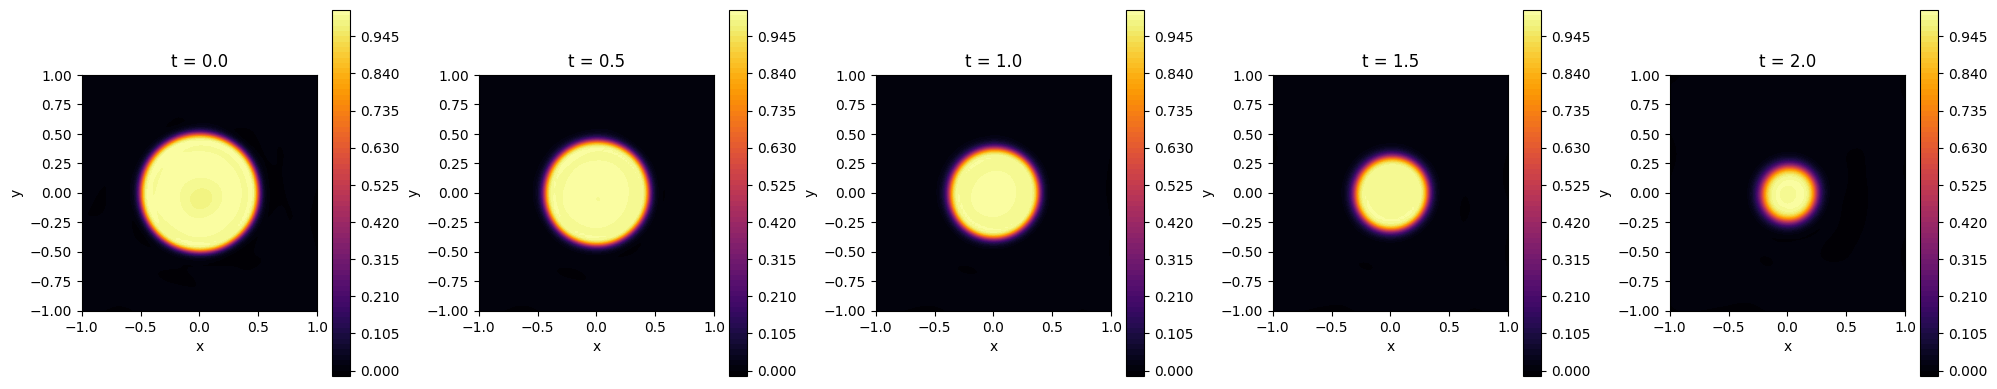

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Time steps to visualize
t_vals = [0.0, 0.5, 1.0, 1.5, 2.0]

# Grid for 2D domain
x_plot = np.linspace(-1, 1, 100)
y_plot = np.linspace(-1, 1, 100)
xm, ym = np.meshgrid(x_plot, y_plot)
x_flat = xm.flatten()[:, None]
y_flat = ym.flatten()[:, None]

# Create subplots
fig, axes = plt.subplots(1, len(t_vals), figsize=(4 * len(t_vals), 4))

for ax, t_val in zip(axes, t_vals):
    t_flat = np.full_like(x_flat, t_val)
    X_test = tf.convert_to_tensor(np.hstack([x_flat, y_flat, t_flat]), dtype=tf.float32)
    u_pred = model(X_test)
    u_plot = u_pred.numpy().reshape(100, 100)

    # Filled contour plot (entire 2D profile)
    c = ax.contourf(x_plot, y_plot, u_plot, levels=100, cmap='inferno')
    ax.set_title(f"t = {t_val}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')  # Maintain true aspect ratio
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


Visualization below tracks how the interface evolves along a 1D horizontal slice of the 2D domain — specifically along the line y=0y=0, which passes through the center of the initial disc.

At several time points, the model is queried along this line to obtain the predicted values of u(x, t). The resulting plot shows how the profile changes over time, revealing the movement and smoothing of the interface as governed by the underlying equation.

This kind of 1D slice is especially useful for understanding the dynamics in a simplified way, making it easier to observe how the interface propagates, sharpens, or fades without the complexity of full 2D visualizations.

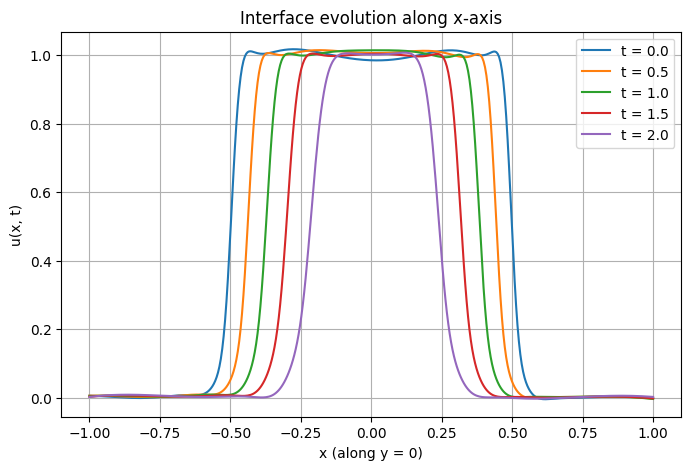

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1D line along x-axis at y = 0
x_line = np.linspace(-1, 1, 400)[:, None]
y_line = np.zeros_like(x_line)

# Time points to evaluate
t_vals = [0.0, 0.5, 1.0, 1.5, 2.0]

plt.figure(figsize=(8, 5))

for t in t_vals:
    t_line = np.full_like(x_line, t)
    X_line = tf.convert_to_tensor(np.hstack([x_line, y_line, t_line]), dtype=tf.float32)
    u_pred = model(X_line).numpy()

    plt.plot(x_line, u_pred, label=f"t = {t}")

plt.xlabel("x (along y = 0)")
plt.ylabel("u(x, t)")
plt.title("Interface evolution along x-axis")
plt.legend()
plt.grid(True)
plt.show()


This visualization extracts and plots the φ = 0.5 contour — the level set typically representing the interface — at different time steps, all on the same 2D plane.

By evaluating the trained model over the entire spatial grid for each selected time point, we generate contour lines where the predicted value equals 0.5. These contours effectively trace the boundary of the evolving region (e.g., phase boundary or interface in a reaction-diffusion system).

Plotting all contours together provides a clear picture of how the shape and size of the interface change over time, revealing behaviors like shrinking, movement, or dissolution of the initial structure. Setting the aspect ratio to equal ensures spatial accuracy in the representation.

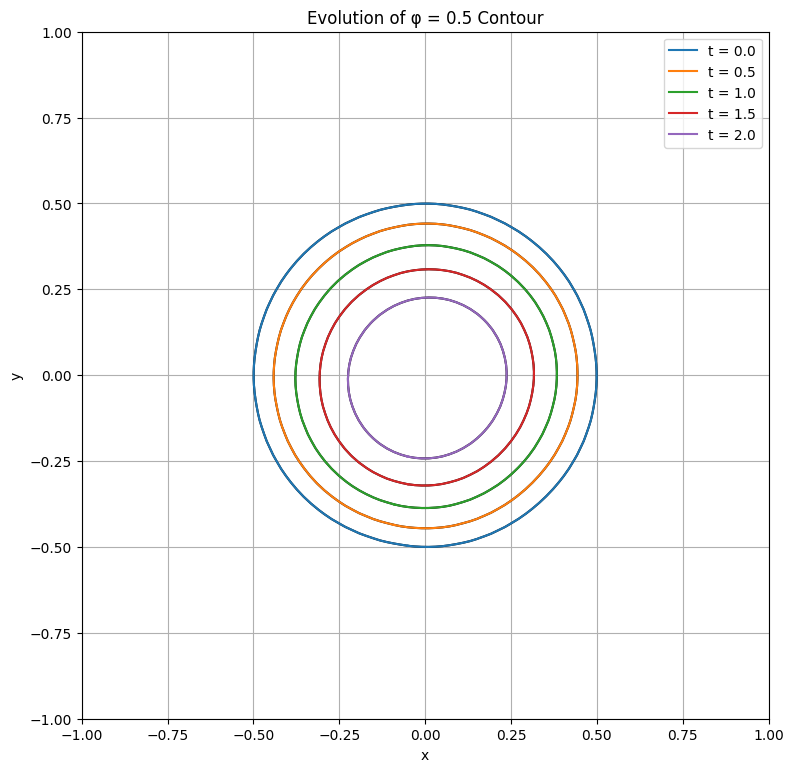

In [ ]:
# Extract phi=0.5 contour profile over time and plot together
from matplotlib import cm
from matplotlib import collections as mc

contour_data = []
t_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
x_plot = np.linspace(-1, 1, 100)
y_plot = np.linspace(-1, 1, 100)
xm, ym = np.meshgrid(x_plot, y_plot)
x_flat = xm.flatten()[:, None]
y_flat = ym.flatten()[:, None]

plt.figure(figsize=(8, 8))
for t_val in t_vals:
    t_flat = np.full_like(x_flat, t_val)
    X_test = tf.convert_to_tensor(np.hstack([x_flat, y_flat, t_flat]), dtype=tf.float32)
    u_pred = model(X_test)
    u_plot = u_pred.numpy().reshape(100, 100)

    contour_set = plt.contour(x_plot, y_plot, u_plot, levels=[0.5], colors='k')
    # Access paths using allsegs instead of collections
    for path in contour_set.allsegs[0]:  # Changed line
        vertices = path
        plt.plot(vertices[:, 0], vertices[:, 1], label=f't = {t_val}')


plt.gca().set_aspect('equal')
plt.legend()
plt.title("Evolution of φ = 0.5 Contour")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.show()